In [77]:
%matplotlib inline  
import os
import pandas as pd
import yfinance as yf
import re
import datetime
import numpy as np
import matplotlib.pyplot as plt
import logging
import pyarrow as pa
import pyarrow.parquet as pq
from scipy import stats
from scipy.signal import savgol_filter
import datetime
logger = logging.getLogger()


For every sector, group stocks together by sector and average the correlation distributions. Also calculate average distribution across all stocks.

For every ticker, compare its distribution of correlations to the global average and to the average of the corresponding sector.

In [202]:
# load data
# parameters
# ============================================================
window_size = 10
ticker = "GME"
start_date = datetime.datetime(day=1, month=1, year=2021)
end_date = datetime.datetime(day=1, month=1, year=2022)
# ============================================================

# read parquet file, convert to dataframe, then select our dates
table = pq.read_table(f'./data/{window_size}/{ticker}.parquet')
df = table.to_pandas()
if start_date is not None:
    df = df[df.index>=start_date]
if end_date is not None:
    df = df[df.index<end_date]

# remove tickers that have null values
na_idx = np.where(df.isna().sum()>0)[0]
tmp = df.isna().sum()
bads = tmp[na_idx]/len(df)>0
for bad_ticker in bads.index[bads==True]:   
    df = df.drop(bad_ticker, axis=1)
    
# create bins for counting correlation of periods
dist = dict()
dist['bins'] = np.arange(-1.0, 1.01, .01)


# load ticker info, get sectors
ticker_info = pd.read_csv('stock_monitor_tickers.csv')
sectors = ticker_info['Sector'].unique()

# get global distribution 
# combine all the correlation scores and get the histogram of it
# use savitzky-golay filter to smooth it out
global_corr = np.reshape(df.to_numpy(), [-1,1])
global_n, _ = np.histogram(global_corr, bins=dist['bins'])
global_n = savgol_filter(global_n, 51, 1)
global_n = global_n/np.sum(global_n)
dist['Global'] = global_n

# get distributions for each sector
ticker_pool = set(df.columns)
for sector in sectors:    
    # get the tickers in this sector
    idx = ticker_info['Sector']==sector
    sector_tickers = set(ticker_info.loc[idx, 'Symbol'])
    # valid tickers are those that are in this sector and that we have data for
    valid_tickers = list(sector_tickers & ticker_pool)
    if ticker in valid_tickers: # don't include yourself in correlations
        valid_tickers.remove(ticker)
    # lump everything together and calculate the histogram, use savgol to smoooth
    sector_corr = np.reshape(df[valid_tickers].to_numpy(), [-1,1])
    sector_n,_ = np.histogram(sector_corr, bins=dist['bins'])
    sector_n = savgol_filter(sector_n, 51, 1)
    sector_n = sector_n/np.sum(sector_n)
    dist[sector] = sector_n

# for every symbol, get is correlation distribution
# smooth it out a little with 1st-order savitzky-golay (moving average)
global_res = pd.DataFrame(columns=['ks','p'], index=df.columns)
sector_res = pd.DataFrame(columns=['ks','p'], index=df.columns)

for symbol in df.columns:            
    n, _ = np.histogram(df[symbol], dist['bins'])
    if sum(n)==0:
        continue           
    n = savgol_filter(n, 51, 1)
    n = n/np.sum(n)
    r = stats.kstest(dist['Global'], n)
    global_res.loc[symbol, 'ks'] = r.statistic
    global_res.loc[symbol, 'p'] = r.pvalue
    
    sector = ticker_info.loc[ticker_info['Symbol']==symbol, 'Sector']
    if len(sector)==0:
        continue
    sector = sector.iloc[0]    
    r = stats.kstest(dist[sector], n)
    sector_res.loc[symbol,'ks'] = r.statistic
    sector_res.loc[symbol,'p'] = r.pvalue
    sector_res.loc[symbol,'sector'] = sector

# save the output
tmp = dist.copy()
tmp['bins'] = tmp['bins'][0:-1]
distributions = pd.DataFrame(tmp)
distributions.index=distributions['bins']
distributions = distributions.drop('bins', axis=1)

start_txt = ""
end_txt = ""
if start_date is not None:
    start_txt = start_date.strftime("%b-%d-%Y")
else:
    start_txt = "Beginning"
if end_date is not None:
    end_txt = end_date.strftime("%b-%d-%Y")
else:
    end_txt = "Present-Day"
tag = f"{window_size}_{start_txt}_{end_txt}"
distributions.to_csv(f'distributions_{tag}.csv')
global_res.to_csv(f'global_scores_{tag}.csv')
sector_res.to_csv(f'sector_scores_{tag}.csv')




In [83]:
window_size = 10
ticker="GME"

table = pq.read_table(f'./data/{window_size}/{ticker}.parquet')
df = table.to_pandas()


start_date = datetime.datetime(day=1, month=1,year=2021)
end_date = datetime.datetime(day=1, month=1, year=2022)

if start_date is not None:
    start_txt = start_date.strftime("%b-%d-%Y")
else:
    start_txt = "Beginning"
if end_date is not None:
    end_txt = end_date.strftime("%b-%d-%Y")
else:
    end_txt = "Present-Day"


global_res = pd.read_csv(f'distributions/global_scores_{ticker}_{window_size}_{start_txt}_{end_txt}.csv', index_col=0)
distributions = pd.read_csv(f'distributions/distributions_{ticker}_{window_size}_{start_txt}_{end_txt}.csv', index_col='bins')
dist = distributions.to_dict('list')
dist['bins'] = distributions.index.to_numpy()
order = global_res['ks'].sort_values(ascending=False)
out = global_res.loc[order.index]
out = out.drop(ticker)

In [53]:
idx=0
title = "Correlation distributions:"
print(title+" "+start_txt+" to "+end_txt)
group_size = 50
while idx<len(out):
    print(f"{idx} of {len(out)}", end='\r' )
    legends = list()
    legends.append("Global")
    figure = plt.figure(figsize=(16,9))
    plt.plot(dist['bins'], dist['Global'],color='black',linewidth=5)

    if idx+group_size>len(out):
        ticker_list = list(out.index[idx:-1])        
    else:
        ticker_list = list(out.index[idx:idx+group_size])    

    for i in ticker_list:        
        n,_ = np.histogram(df[i], bins=np.arange(-1,1.01,.01))
        n = n/np.sum(n)
        n = savgol_filter(n, 51, 1)
        plt.plot(dist['bins'], n, linewidth=2)    
        legends.append(f"{i}:ks={out.loc[i,'ks']}, p={out.loc[i,'p']}")

    plt.ylim([-.0025, .02])
    plt.legend(legends,prop={'size': 14})
    

    plt.title(title+" "+start_txt+" to "+end_txt, fontsize=20)
    os.makedirs(f"./plots/global/{window_size}/{start_txt}_{end_txt}/", exist_ok=True)
    plt.savefig(f"./plots/global/{window_size}/{start_txt}_{end_txt}/{idx}_{idx+4}.png", dpi=200, facecolor="white")
    plt.close()
    idx+=group_size
    print(" "*80, end='\r')
    


Correlation distributions: Jan-01-2021 to Jan-01-2022


In [87]:
window_size = 10
ticker="GME"

table = pq.read_table(f'./data/{window_size}/{ticker}.parquet')
df = table.to_pandas()


start_date = datetime.datetime(day=1, month=1,year=2022)
end_date = datetime.datetime(day=1, month=7, year=2022)

if start_date is not None:
    start_txt = start_date.strftime("%b-%d-%Y")
else:
    start_txt = "Beginning"
if end_date is not None:
    end_txt = end_date.strftime("%b-%d-%Y")
else:
    end_txt = "Present-Day"

global_res = pd.read_csv(f'distributions/global_scores_{ticker}_{window_size}_{start_txt}_{end_txt}.csv', index_col=0)
distributions = pd.read_csv(f'distributions/distributions_{ticker}_{window_size}_{start_txt}_{end_txt}.csv', index_col='bins')
dist = distributions.to_dict('list')
dist['bins'] = distributions.index.to_numpy()
order = global_res['ks'].sort_values(ascending=False)
out = global_res.loc[order.index]
out = out.drop(ticker)

idx=0
title = "Correlation distributions:"
print(title+" "+start_txt+" to "+end_txt)
group_size = 100
print(f"{idx} of {len(out)}", end='\r' )
figure = plt.figure(figsize=(16,9))

legends = list()

if idx+group_size>len(out):
    ticker_list = list(out.index[idx:-1])        
else:
    ticker_list = list(out.index[idx:idx+group_size])    

for i in ticker_list:        
    n,_ = np.histogram(df[i], bins=np.arange(-1,1.01,.01))
    n = n/np.sum(n)
    n = savgol_filter(n, 51, 1)
    plt.plot(dist['bins'], n, linewidth=2)    
    legends.append(f"{i}:ks={out.loc[i,'ks']}, p={out.loc[i,'p']}")

legends.append("Global")
plt.plot(dist['bins'], dist['Global'],color='black',linewidth=5)

plt.ylim([-.0025, .02])
if group_size<10:
    plt.legend(legends,prop={'size': 14})

plt.title(title+" "+start_txt+" to "+end_txt, fontsize=20)
os.makedirs(f"./plots/global/{ticker}/{window_size}/{start_txt}_{end_txt}/", exist_ok=True)
plt.savefig(f"./plots/global/{ticker}/{window_size}/{start_txt}_{end_txt}/{idx}_{idx+group_size-1}.png", dpi=200, facecolor="white")
plt.close()
idx+=5
print(" "*80, end='\r')
    

Correlation distributions: Jan-01-2022 to Jul-01-2022


In [79]:
df

,ON,MTB,BAX,ACI,UNM,PACW,EA,AMAT,CAH,ACGL,...,GEHI,BYND,FTNT,MHK,HXL,PPC,RRX,WE,MCO,PINS
timestamp,,,,,,,,,,,,,,,,,,,,,
2017-01-03,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2017-01-04,1.000000,1.000000,1.000000,NaN,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,...,NaN,NaN,1.000000,1.000000,1.000000,1.000000,1.000000,NaN,1.000000,NaN
2017-01-05,0.578963,0.977671,-0.390928,NaN,0.772968,0.937135,0.956675,0.562686,0.910499,0.994281,...,NaN,NaN,-0.479713,0.468508,0.946445,0.290449,0.929242,NaN,-0.207090,NaN
2017-01-06,-0.106148,0.643380,-0.781947,NaN,0.023684,0.230714,0.848254,0.514874,0.232258,0.124776,...,NaN,NaN,-0.752158,0.196927,0.962740,0.760516,0.971348,NaN,-0.567258,NaN
2017-01-09,-0.492764,0.688531,-0.817217,NaN,0.215455,0.518419,0.882738,-0.355667,0.296395,0.457755,...,NaN,NaN,-0.827643,0.225281,0.950211,0.770044,0.974310,NaN,-0.407987,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2022-08-17,0.095390,0.172475,0.341750,0.252496,0.140574,0.182584,0.113943,-0.094500,0.123849,0.156871,...,0.004585,0.647342,0.143644,0.348115,0.224806,0.634113,0.048454,0.255055,0.069601,0.213865
2022-08-18,-0.248315,-0.327830,-0.067899,-0.253283,-0.404773,-0.197709,0.170887,0.032633,-0.258605,-0.338375,...,0.334822,0.654364,0.227057,0.196001,0.046851,0.223291,-0.388053,0.210730,-0.176671,0.218579
2022-08-19,-0.430513,-0.412671,-0.247806,-0.578975,-0.591125,-0.084819,0.284531,0.190672,-0.402632,-0.494956,...,0.608110,0.862577,0.515626,0.518066,0.377854,-0.144681,-0.509832,0.475190,0.137299,0.582164


(-1.0, 1.0)

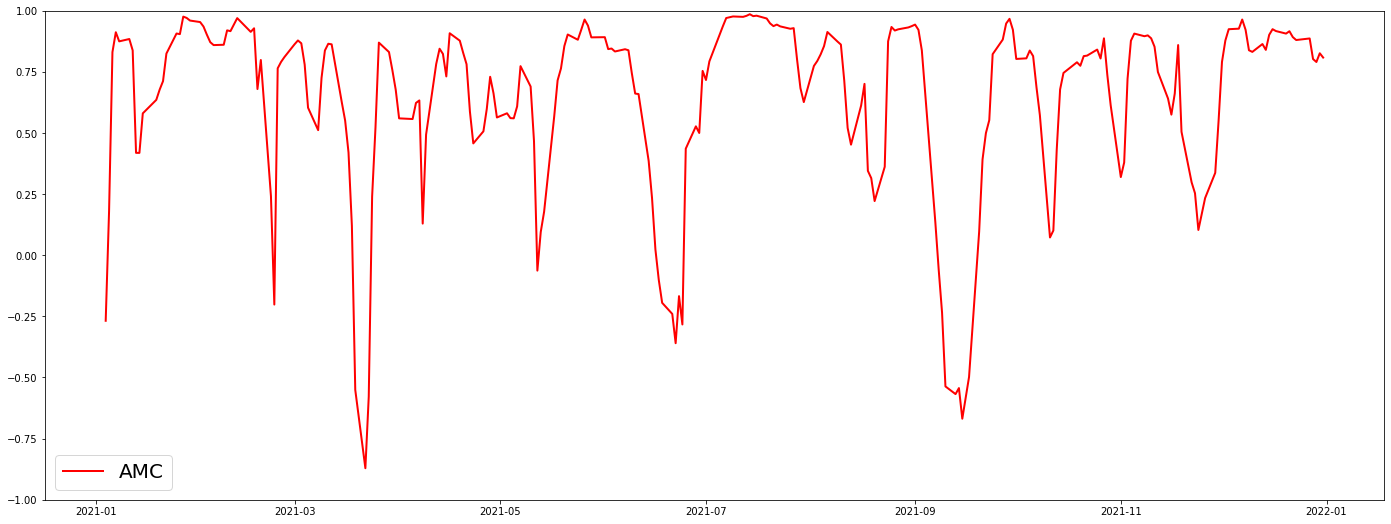

In [104]:
window_size = 10
ticker="GME"

table = pq.read_table(f'./close/{window_size}/{ticker}.parquet')
df = table.to_pandas()

start_date = datetime.datetime(day=1, month=1,year=2021)
stop_date = datetime.datetime(day=1, month=1, year=2022)

df = df[df.index>start_date]
df = df[df.index<=stop_date]

plt.figure(figsize=(24,9))
legends = list()
colors=['red']
for t,color in zip(['AMC'],colors):
    plt.plot(df[t], linewidth=2, color=color)
    legends.append(t)
plt.legend(legends,prop={'size': 20} )
plt.ylim([-1, 1])


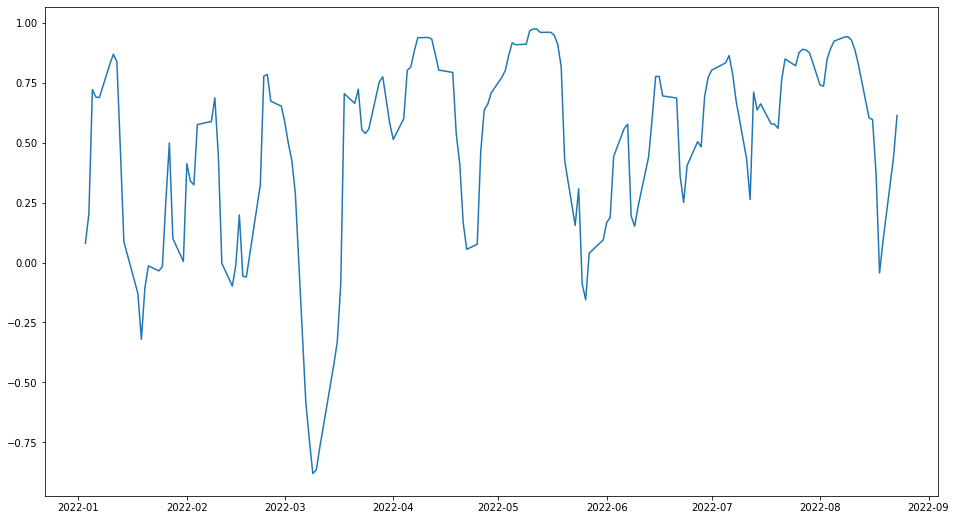

In [14]:
# read parquet file, convert to dataframe, then select our dates
window_size = 10
ticker="GME"
table = pq.read_table(f'./data/{window_size}/{ticker}.parquet')
df = table.to_pandas()
start_date = datetime.datetime(day=1, month=1, year=2022)
stop_date = datetime.datetime(day=1, month=9, year=2022)
idx = np.logical_and(df.index>=start_date, df.index<stop_date)
data = df.loc[idx]

plt.figure(figsize=(16,9))
plt.plot(data['BBBY'])

In [19]:
np.where(out.index=='BB')

(array([77], dtype=int64),)

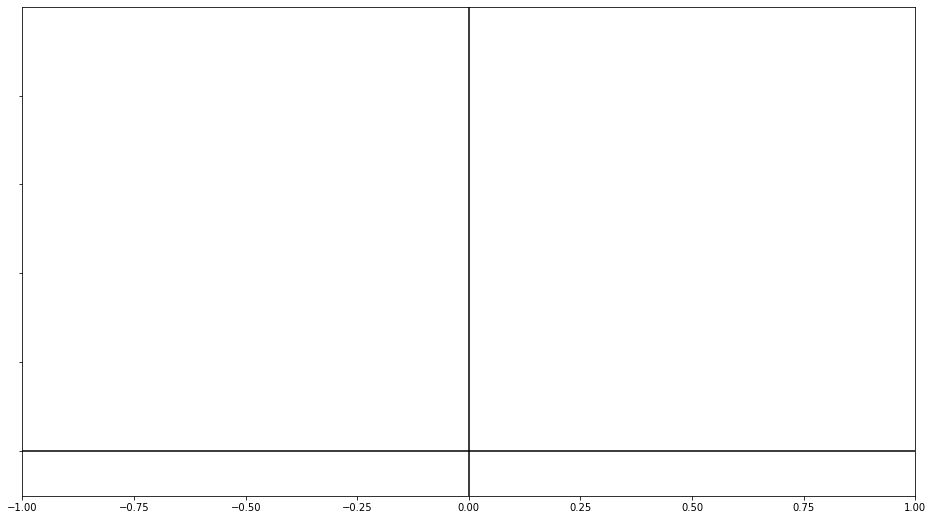

In [97]:
figure = plt.figure(figsize=(16,9))
plt.yticks(ticks=np.arange(0,1,.2), labels=[])
#plt.yticks([])
plt.ylim([-.1, 1])
plt.xlim([-1.0, 1.0])
plt.hlines(0,-1,1,color='black')
plt.vlines(0,-.1,1,color='black')

In [ ]:
import subprocess
import os
files = os.listdir('distributions')
files = [f for f in files if 'distributions' in f]
for f in files:
    subprocess.run(['python','generate_distribution_plots.py', f"distributions/{f}"])


In [1]:
import logging
import pandas as pd
import yfinance as yf
ticker = "GME"
d = yf.Ticker(ticker).history(period="max")

In [2]:
d

,Open,High,Low,Close,Volume,Dividends,Stock Splits
Date,,,,,,,
2002-02-13,1.620129,1.693350,1.603296,1.691667,76216000,0.0,0.0
2002-02-14,1.712707,1.716074,1.670626,1.683251,11021600,0.0,0.0
2002-02-15,1.683250,1.687458,1.658002,1.674834,8389600,0.0,0.0
2002-02-19,1.666418,1.666418,1.578047,1.607504,7410400,0.0,0.0
2002-02-20,1.615921,1.662210,1.603296,1.662210,6892800,0.0,0.0
...,...,...,...,...,...,...,...
2022-08-18,39.270000,40.070000,37.340000,37.930000,8145400,0.0,0.0
2022-08-19,35.180000,37.189999,34.669998,36.490002,9525600,0.0,0.0
2022-08-22,34.310001,36.200001,34.200001,34.500000,5798600,0.0,0.0


In [68]:
import pyarrow as pa
import pyarrow.parquet as pq
import os
from datetime import datetime
from datetime import timedelta
import numpy as np

data_type = "close"
window_size=10
ticker = "GME"
start_date = datetime(year=2020, month=1, day=1)
stop_date = datetime(year=2021, month=1, day=1)
table = pq.read_table(os.path.join(data_type, str(window_size), f'{ticker}.parquet'))
df = table.to_pandas()
df = df.drop(ticker, axis=1)
df = df[df.index>=start_date]
df = df[df.index<stop_date]

a = timedelta(seconds=stop_date.timestamp() - start_date.timestamp())
n_days = a.days - 1
positives = df[df>.75].sum().sort_values(ascending=False)/n_days
negatives = df[df<-.75].sum().sort_values(ascending=True)/n_days
positives = positives.to_frame().reset_index()
positives.columns=['symbol', 'sum']
negatives = negatives.to_frame().reset_index()
negatives.columns=['symbol', 'sum']

In [73]:
a = timedelta(seconds=stop_date.timestamp() - start_date.timestamp())

In [75]:
a.days - 1

365

2022-08-27 19:39:40,159 - main - INFO - Generating plots for GME, window=10, 2022-01-01 to 2022-07-01
2022-08-27 19:39:40,159 - main - INFO - Generating plots for GME, window=10, 2022-01-01 to 2022-07-01
2022-08-27 19:39:40,159 - main - INFO - Generating plots for GME, window=10, 2022-01-01 to 2022-07-01
2022-08-27 19:39:40,159 - main - INFO - Generating plots for GME, window=10, 2022-01-01 to 2022-07-01
2022-08-27 19:39:40,159 - main - INFO - Generating plots for GME, window=10, 2022-01-01 to 2022-07-01
2022-08-27 19:39:40,159 - main - INFO - Generating plots for GME, window=10, 2022-01-01 to 2022-07-01
2022-08-27 19:39:40,159 - main - INFO - Generating plots for GME, window=10, 2022-01-01 to 2022-07-01
2022-08-27 19:39:40,159 - main - INFO - Generating plots for GME, window=10, 2022-01-01 to 2022-07-01
2022-08-27 19:39:40,159 - main - INFO - Generating plots for GME, window=10, 2022-01-01 to 2022-07-01
2022-08-27 19:39:40,159 - main - INFO - Generating plots for GME, window=10, 2022-

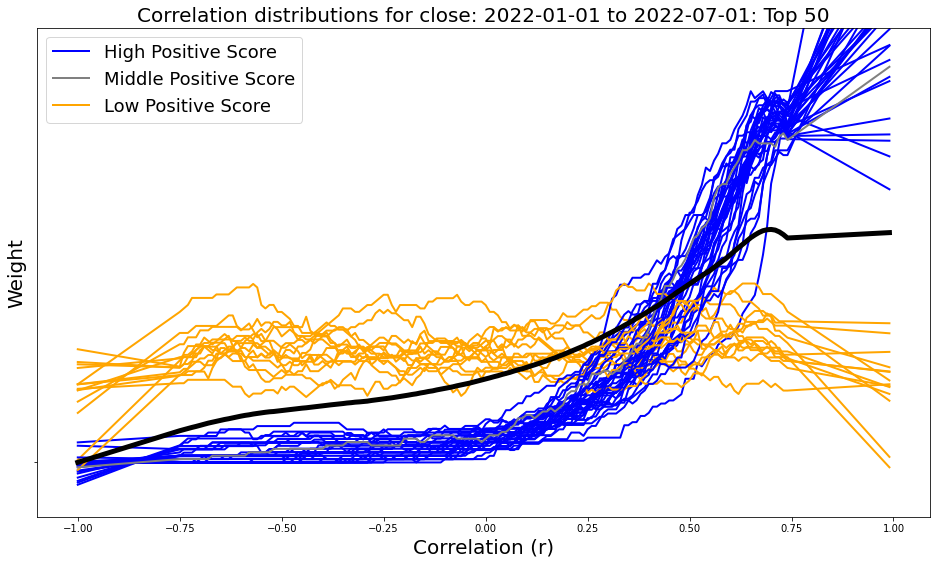

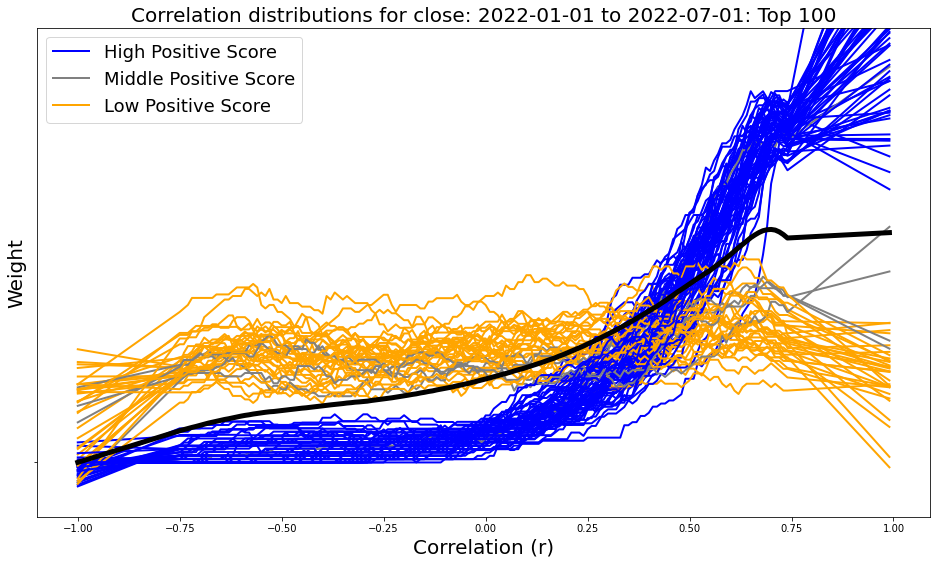

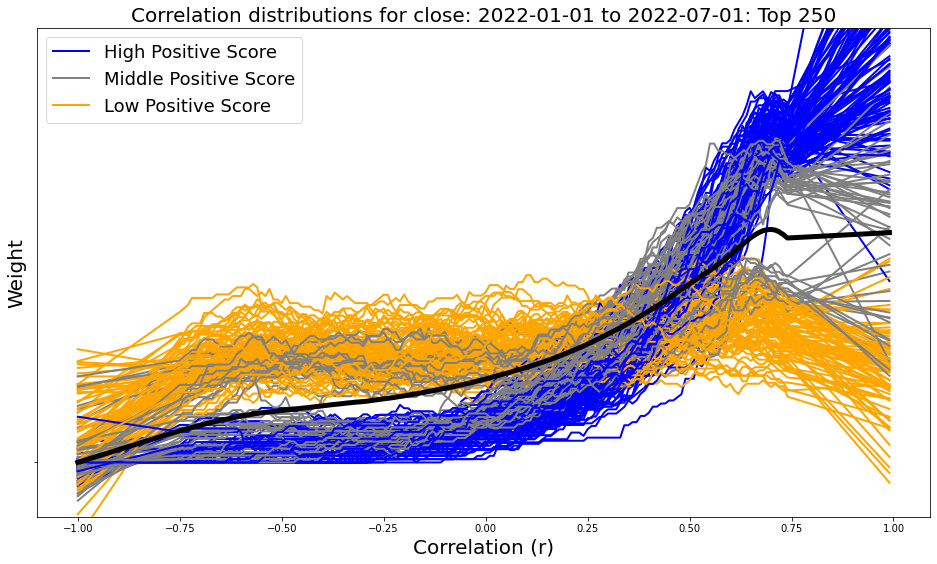

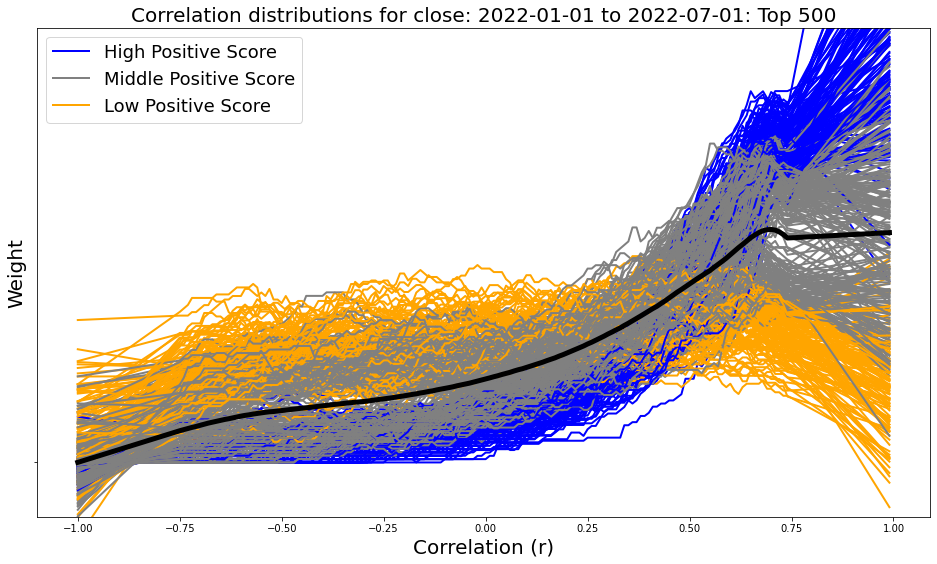

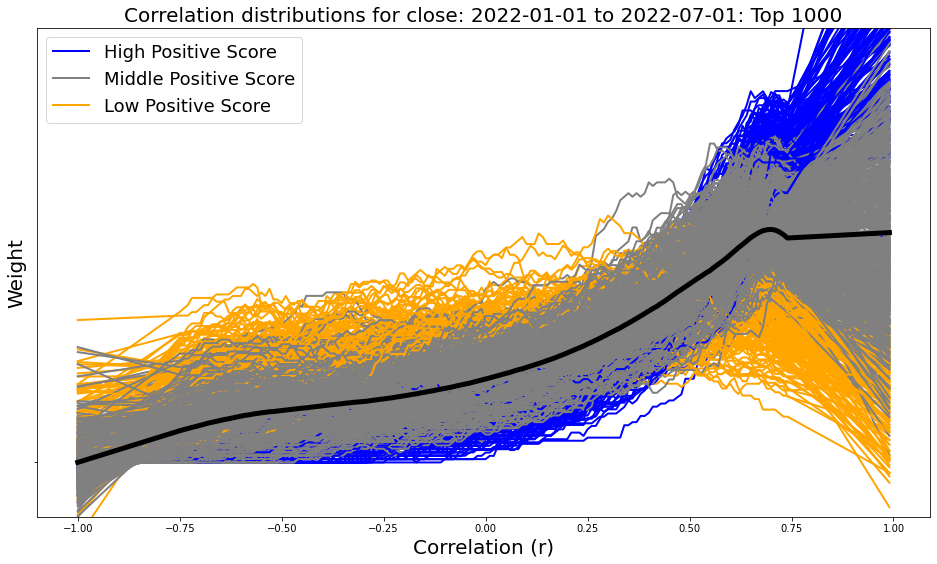

2022-08-27 19:39:44,591 - main - INFO - Completed generating plots
2022-08-27 19:39:44,591 - main - INFO - Completed generating plots
2022-08-27 19:39:44,591 - main - INFO - Completed generating plots
2022-08-27 19:39:44,591 - main - INFO - Completed generating plots
2022-08-27 19:39:44,591 - main - INFO - Completed generating plots
2022-08-27 19:39:44,591 - main - INFO - Completed generating plots
2022-08-27 19:39:44,591 - main - INFO - Completed generating plots
2022-08-27 19:39:44,591 - main - INFO - Completed generating plots
2022-08-27 19:39:44,591 - main - INFO - Completed generating plots
2022-08-27 19:39:44,591 - main - INFO - Completed generating plots
2022-08-27 19:39:44,591 - main - INFO - Completed generating plots
2022-08-27 19:39:44,591 - main - INFO - Completed generating plots


In [117]:
import pandas as pd
import numpy as np
import datetime
import pyarrow as pa
import pyarrow.parquet as pq
from scipy import stats
from scipy.signal import savgol_filter
import logging
import argparse
from matplotlib import pyplot as plt
import os
import re
logger = logging.getLogger("main")
ch = logging.StreamHandler()
ch.setLevel(logging.INFO)
formatter = logging.Formatter('%(asctime)s - %(name)s - %(levelname)s - %(message)s')
ch.setFormatter(formatter)

fh = logging.FileHandler("log.log")
fh.setLevel(logging.DEBUG)
fh.setFormatter(formatter)
logger.addHandler(ch)
logger.addHandler(fh)
logger.setLevel(logging.DEBUG)

# argument handling

parser = argparse.ArgumentParser()
#parser.add_argument("ticker", type=str, help="The source ticker you want to correlate everything with")
#parser.add_argument("window_size", type=int, help="The length of the rolling window of the data you want to use")
parser.add_argument("input_file", type=str, help="The distributions file to serve as input")

#parser.add_argument("--start", nargs=3, type=int, default=[1, 1, 2021],help="Start date. Use three numbers, day month year, with months and days starting at 1. For example --start 15 3 2020 is the 15th of March, 2020")
#parser.add_argument("--stop", nargs=3, type=int, default=[1,1,2022], help="Stop date. Use three numbers, day month year, with months and days starting at 1. For example --start 27 6 2021 is the 27th of June, 2021")
parser.add_argument("--no-smoothing", "-s", action='store_true', default=False, help="Turns off smoothing of distributions")
parser.add_argument("--smoothing-window", "-w", type=int, default=51, help="Size of the smoothing window. Must be odd")
parser.add_argument("--smoothing-order", "-r", type=int, default=1, help="The order of the savitzky-golay filter used in smoothing")
parser.add_argument("--overwrite", "-o", action="store_true", default=False, help="If there are already existing plots, decide whether or not to overwrite them")

args = parser.parse_args(['close\distributions\results_GME_close_10_2022-01-01_2022-07-01.csv','-o'])

overwrite = args.overwrite
input_file = args.input_file

if "distributions" not in args.input_file:    
    raise Exception("Please use a 'distributions' csv file as input")
tmp = os.path.splitext(os.path.basename(input_file))[0].split("_")
ticker = tmp[1]
data_type = tmp[2]
window_size = tmp[3]
start = tmp[4]
stop = tmp[5]
start_date = datetime.datetime.strptime(start, "%Y-%m-%d")
stop_date = datetime.datetime.strptime(stop, "%Y-%m-%d")
smoothing = not args.no_smoothing

if smoothing and args.smoothing_window%2==0:
    raise Exception("Length of smoothing window must be odd-valued")
smoothing_window = args.smoothing_window
smoothing_order = args.smoothing_order



# read the data
table = pq.read_table(os.path.join(data_type, str(window_size), f'{ticker}.parquet'))
df = table.to_pandas()
df = df[df.index>=start_date]
df = df[df.index<stop_date]
    
base_folder = os.path.join(data_type, "distributions")
results = pd.read_csv(os.path.join(base_folder,f'results_{ticker}_{data_type}_{window_size}_{start}_{stop}.csv'), index_col=0)
#global_res = pd.read_csv(os.path.join(base_folder,f'global-scores_{ticker}_{data_type}_{window_size}_{start}_{stop}.csv'), index_col=0)
#sector_res = pd.read_csv(os.path.join(base_folder, f'sector-scores_{ticker}_{data_type}_{window_size}_{start}_{stop}.csv'), index_col=0)
distributions = pd.read_csv(os.path.join(base_folder,f'distributions_{ticker}_{data_type}_{window_size}_{start}_{stop}.csv'), index_col='bins')

dist = distributions.to_dict('list')
dist['bins'] = distributions.index.to_numpy()

# do global plots
order = results['global_ks'].sort_values(ascending=False)
out = results.loc[order.index]


def plot_group(idx, group_size, title, plot_legend=True):
    output_filename = os.path.join(data_type, "plots", "global", ticker, str(window_size), f"{start}_{stop}", f"{idx}_{idx+group_size-1}.png")
    if os.path.exists(output_filename) and not overwrite:
        logger.warning(f"File exists for {output_filename} with overwrite=False, skipping...")
        return
    legends = list()    
    figure = plt.figure(figsize=(16,9))   

    if idx+5>len(out):
        ticker_list = list(out.index[idx:-1])        
    else:
        ticker_list = list(out.index[idx:idx+group_size])    
    
    for i in ticker_list:        
        n,_ = np.histogram(df[i], bins=np.arange(-1,1.01,.01))
        if smoothing:
            n = savgol_filter(n, smoothing_window, smoothing_order)
        n = n/np.sum(n)        
        if results.loc[i]['pos_score']>results['pos_score'].mean()+results['pos_score'].std():
            color = 'blue'
        elif results.loc[i]['pos_score']<results['pos_score'].mean()-results['pos_score'].std():
            color = 'orange'
        else:
            color= 'grey'
        plt.plot(dist['bins'], n, linewidth=2, color=color)    
        legends.append(f"{i}:ks={out.loc[i,'global_ks']}, p={out.loc[i,'global_p']}")
    plt.yticks(ticks=np.arange(0,1,.2), labels=[])
    legends.append("Global")
    plt.plot(dist['bins'], dist['Global'],color='black',linewidth=5)
    
    plt.ylim([-.0025, .02])  
    if plot_legend:
        plt.legend(legends,prop={'size': 14})   
    lg = plt.legend(['High Positive Score', 'Middle Positive Score','Low Positive Score'], prop={'size': 18})
    lg.legendHandles[0].set_color('blue')    
    lg.legendHandles[1].set_color('grey')
    lg.legendHandles[2].set_color('orange')
    plt.xlabel("Correlation (r)", fontsize=20)
    plt.ylabel("Weight", fontsize=20)

    plt.title(title, fontsize=20)
    #os.makedirs(os.path.dirname(output_filename), exist_ok=True)
    #plt.savefig(output_filename, dpi=200, facecolor="white")
    plt.show()
    #plt.close() 
    


idx=0
title = f"Correlation distributions for {data_type}:"
logger.info(f"Generating plots for {ticker}, window={window_size}, {start} to {stop}")
group_size = 5
title = title+" "+start+" to "+stop
'''
while idx<len(out):   
    msg = f"{idx} of {len(out)}"
    print(msg, end='\r' )
    if idx%100==0:
        logger.debug(msg)
    plot_group(idx, group_size, title=title, plot_legend=True)
    idx+=group_size    
    print(" "*80, end='\r')
'''
# plot top 50 and top 100 
plot_group(0, 50, title=title+": Top 50", plot_legend=False)
plot_group(0, 100, title=title+": Top 100", plot_legend=False)
plot_group(0, 250, title=title+": Top 250", plot_legend=False)
plot_group(0, 500, title=title+": Top 500", plot_legend=False)
plot_group(0, 1000, title=title+": Top 1000", plot_legend=False)
logger.info("Completed generating plots")
    